In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [24]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(recent_date)

#recent_date = session.query(func.max(measurement.date)).scalar()
#print(recent_date)

('2017-08-23',)


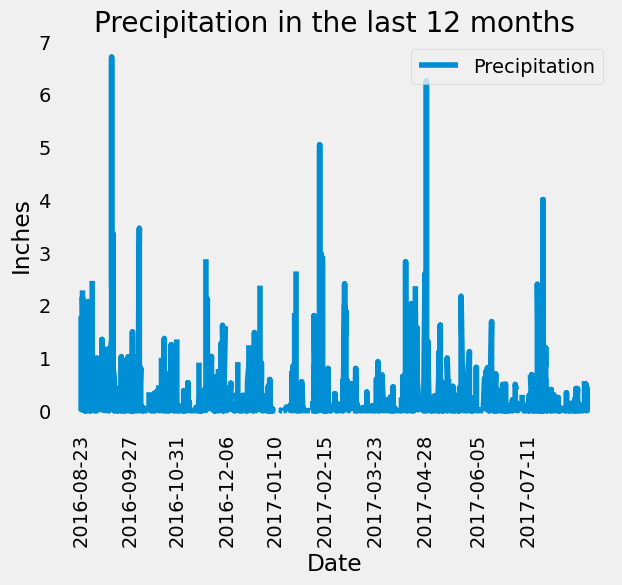

In [67]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
year, month, day = map(int, recent_date[0].split('-'))
recent_date_value = dt.date(year, month, day)

# Calculate the date one year from the last date in data set.
year_ago = recent_date_value - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
pscores_df = pd.DataFrame(precipitation_scores, columns=['date', 'precipitation'])

# Sort the dataframe by date
pscores_df = pscores_df.sort_values(by='date')

# Reset the index
pscores_df = pscores_df.reset_index(drop=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(pscores_df['date'], pscores_df['precipitation'], label="Precipitation")

plt.title("Precipitation in the last 12 months")

#x_positions = np.arange(0, len(pscores_df['date']), int(len(pscores_df['date'])/10))
x_labels = pscores_df['date'][::int(len(pscores_df['date'])/10)]
plt.xticks(x_labels, rotation=90)

plt.xlabel("Date")
plt.ylabel("Inches")

plt.legend(loc="upper right")
plt.grid()


#plt.tight_layout()
plt.show()

In [69]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = pscores_df['precipitation'].describe()
print(summary_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [75]:
# Design a query to calculate the total number of stations in the dataset
stations_count = session.query(func.count(measurement.station.distinct())).scalar()
stations_count

9

In [88]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

count_by_station = session.query(measurement.station, func.count(measurement.station).label('count')).\
                                 group_by(measurement.station).\
                                 order_by(func.count(measurement.station).desc()).all()

for station, count in count_by_station:
    print(f'Station: {station}, Count: {count}')

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [106]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
max_temp = session.query(func.max(measurement.tobs)).\
                filter(measurement.station == count_by_station[0][0]).all()

min_temp = session.query(func.min(measurement.tobs)).\
                filter(measurement.station == count_by_station[0][0]).all()

avg_temp = session.query(func.avg(measurement.tobs)).\
                filter(measurement.station == count_by_station[0][0]).all()


print(f'Station: {count_by_station[0][0]}, Max Temp: {max_temp}')
print(f'Station: {count_by_station[0][0]}, Min Temp: {min_temp}')
print(f'Station: {count_by_station[0][0]}, Avg Temp: {avg_temp}')



Station: USC00519281, Max Temp: [(85.0,)]
Station: USC00519281, Min Temp: [(54.0,)]
Station: USC00519281, Avg Temp: [(71.66378066378067,)]


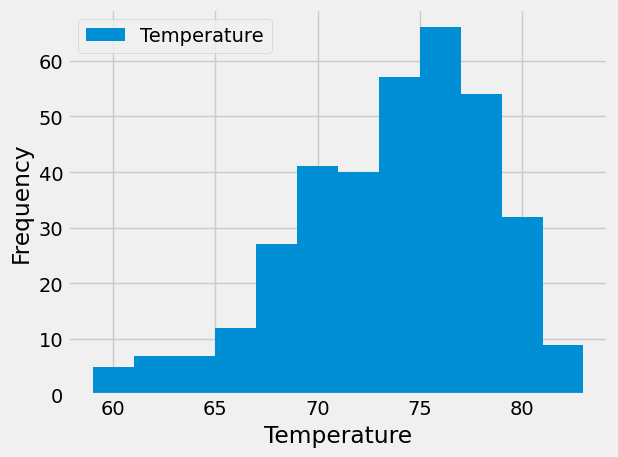

In [124]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

recent_date_v1 = session.query(measurement.date).\
                        filter(measurement.station == count_by_station[0][0]).\
                        order_by(measurement.date.desc()).first()

year_v1, month_v1, day_v1 = map(int, recent_date_v1[0].split('-'))
recent_date_value_v1 = dt.date(year_v1, month_v1, day_v1)
year_ago_v1 = recent_date_value_v1 - dt.timedelta(days=365)

#print(year_ago_v1)

temp_data = session.query(measurement.station, measurement.date, measurement.tobs).\
                filter(measurement.station == count_by_station[0][0]).\
                filter(measurement.date >= year_ago_v1).all()

#temp_data

temp_data_df = pd.DataFrame(temp_data, columns=['station', 'date', 'temp'])
#temp_data_df.head()

plt.hist(temp_data_df['temp'], bins=12, label="Temperature")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


# Close Session

In [125]:
# Close Session
session.close()